Added State method for parametric uncertainty (Inverted Pendulum Example)

Objectives:
Compare zero lvl set evolution and 3D value function for max(v_l, v_u) with max(v_l, v_1, v_2, ..., v_max), as well as disturbance method



In [82]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
from matplotlib import MatplotlibDeprecationWarning
warnings.filterwarnings("ignore", category=MatplotlibDeprecationWarning)
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
import numpy as np

import matplotlib
import pickle as pkl

from scipy.interpolate import interp1d
from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import HTML

import hj_reachability as hj
import utils

Setup Problem (dynamics, environment)

In [83]:
class inv_pend(hj.ControlAndDisturbanceAffineDynamics):
    def __init__(self, uMax=10, dMin=1, dMax=2, params=None,
                 control_mode="min", disturbance_mode="max",
                 control_space=None, disturbance_space=None
                 ):
        self.uMax = jnp.array(uMax)
        self.dMin = jnp.array(dMin)
        self.dMax = jnp.array(dMax)
        if control_space is None:
            control_space = hj.sets.Box(lo=jnp.array([-self.uMax]), hi=jnp.array([self.uMax]))
        if disturbance_space is None:
            disturbance_space = hj.sets.Box(lo=jnp.array([self.dMin]), hi=jnp.array([self.dMax]))
        super().__init__(params, control_mode, disturbance_mode, control_space, disturbance_space)

    def __call__(self, state, control, disturbance, time):
        dx1 = state[1]
        dx2 = -9.81*state[3]*jnp.sin(state[0])+control[0]
        dx3 = 0 #Parameteric dim, represented as nu
        return jnp.array([dx1, dx2, dx3])

    #Don't need to define control jacobian as there's only 1 control input
    def control_jacobian(self, state, time):
        return jnp.array([
            [0],
            [1],
            [0],
        ])
    
    def disturbance_jacobian(self, state, time):
        return jnp.array([
            [0],
            [0],
            [0],
        ])
    
    def open_loop_dynamics(self, state, time):
        return jnp.array([state[1], -9.81*state[3]*jnp.sin(state[0]), 0])

In [84]:
class inv_pend_dist(hj.ControlAndDisturbanceAffineDynamics):
    def __init__(self, uMax=10, dMin=1, dMax=2, params=None,
                 control_mode="min", disturbance_mode="max",
                 control_space=None, disturbance_space=None
                 ):
        self.uMax = jnp.array(uMax)
        self.dMin = jnp.array(dMin)
        self.dMax = jnp.array(dMax)
        if control_space is None:
            control_space = hj.sets.Box(lo=jnp.array([-self.uMax]), hi=jnp.array([self.uMax]))
        if disturbance_space is None:
            disturbance_space = hj.sets.Box(lo=jnp.array([self.dMin]), hi=jnp.array([self.dMax]))
        super().__init__(params, control_mode, disturbance_mode, control_space, disturbance_space)

    def __call__(self, state, control, disturbance, time):
        dx1 = state[1]
        dx2 = -9.81*disturbance[0]*jnp.sin(state[0])+control[0]
        return jnp.array([dx1, dx2])

    #Don't need to define control jacobian as there's only 1 control input
    def control_jacobian(self, state, time):
        return jnp.array([
            [0],
            [1],
        ])
    
    def disturbance_jacobian(self, state, time):
        return jnp.array([
            [0],
            [-9.81*jnp.sin(state[0])],
        ])
    
    def open_loop_dynamics(self, state, time):
        return jnp.array([state[1], 0])

In [85]:
dyn = inv_pend(uMax=3, dMin=1, dMax=1)
dyn_dist = inv_pend_dist(uMax=3, dMin=1, dMax=2)

In [86]:
grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(
    domain = hj.sets.Box(lo=np.array([-jnp.pi, -5, 1]), hi=np.array([jnp.pi,5, 2])),
    shape = (111, 111, 5),
    # Boundary conditions matter for accuracy on the edge of the domain grid.
    # E.g. if we have an angle theta \in [0, 2pi] then we want a periodic boundary in that dim.
    periodic_dims=0,
    #boundary_conditions=(hj.boundary_conditions.extrapolate_away_from_zero,
    #                    hj.boundary_conditions.extrapolate_away_from_zero)
)
grid_dist = hj.Grid.from_lattice_parameters_and_boundary_conditions(
    domain = hj.sets.Box(lo=np.array([-jnp.pi, -5]), hi=np.array([jnp.pi,5])),
    shape = (111, 111),
    # Boundary conditions matter for accuracy on the edge of the domain grid.
    # E.g. if we have an angle theta \in [0, 2pi] then we want a periodic boundary in that dim.
    periodic_dims=0,
    #boundary_conditions=(hj.boundary_conditions.extrapolate_away_from_zero,
    #                    hj.boundary_conditions.extrapolate_away_from_zero)
)
x_init = None
direction = 'backward'

In [87]:
target = jnp.array([[-0.1, 0.1], [-1, 1], [1,2.5]])
target_dist = jnp.array([[-0.1, 0.1], [-1, 1]])
sdf = utils.build_target_sdf(target, 0.1)
sdf_dist = utils.build_target_sdf(target_dist, 0.1)

sdf_values = hj.utils.multivmap(sdf, jnp.arange(grid.ndim))(grid.states)
sdf_values_dist = hj.utils.multivmap(sdf_dist, jnp.arange(grid_dist.ndim))(grid_dist.states)

sdf_values = hj.shapes.shape_ellipse(grid, [0,0,0], [0.1, 0.05, None])
sdf_values_dist = hj.shapes.shape_ellipse(grid_dist, [0,0], [0.1, 0.05])

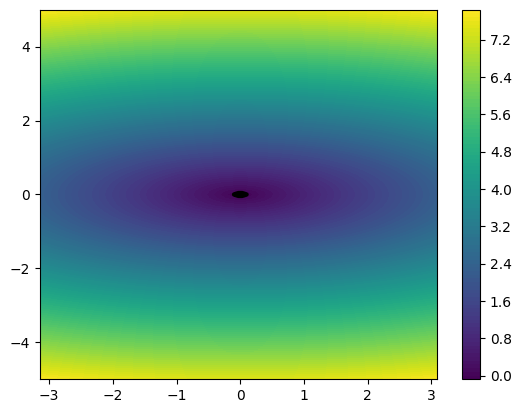

In [88]:
cf = plt.contourf(grid.coordinate_vectors[0], grid.coordinate_vectors[1], sdf_values[:,:,0].T, levels=100)
plt.contour(grid.coordinate_vectors[0], grid.coordinate_vectors[1], sdf_values[:,:,0].T, levels=[0], colors='k', linewidths=3.0)
# add colorbar
plt.colorbar(cf)
hj.viz.visFunc(grid_dist, sdf_values[:,:,0])
hj.viz.visFunc(grid_dist, sdf_values_dist)

In [89]:
hamiltonian_postprocessor = lambda x : jnp.minimum(x,0) #BRT
obstacles = None

accuracy = "very_high"

artificial_dissipation_scheme = hj.artificial_dissipation.global_lax_friedrichs

x_init_for_solving = None

identity = lambda *x: x[-1]
if 'hamiltonian_postprocessor' not in locals():
    hamiltonian_postprocessor=identity

if 'value_postprocessor' not in locals():
    value_postprocessor=identity

solver_settings = hj.SolverSettings.with_accuracy(
    accuracy=accuracy,
    x_init=x_init_for_solving,
    artificial_dissipation_scheme=artificial_dissipation_scheme,
    hamiltonian_postprocessor=hamiltonian_postprocessor,
    value_postprocessor=value_postprocessor,
)
times = np.linspace(0, -3, 100)

In [90]:
times, target_values = hj.solve(
   solver_settings, dyn, grid, times, initial_values=sdf_values)

100%|##########|  3.0000/3.0 [00:11<00:00,  3.71s/sim_s]


In [91]:
times, target_values_dist = hj.solve(
   solver_settings, dyn_dist, grid_dist, times, initial_values=sdf_values_dist)

100%|##########|  3.0000/3.0 [00:01<00:00,  2.09sim_s/s]


In [92]:
(target_values[-1] >= 0).sum() / target_values[-1].size

Array(0.46679652, dtype=float32)

In [93]:
v_l = target_values[:, :, :, 0]
v_u = target_values[:, :, :, -1]

v_int_ext = jnp.maximum(v_l,v_u)
v_int_all = jnp.max(target_values, axis=3)

In [94]:
target_values_dist

Array([[[7.786403 , 7.6564164, 7.526654 , ..., 7.526652 , 7.656416 ,
         7.786403 ],
        [7.7737837, 7.6435843, 7.513602 , ..., 7.5136   , 7.643584 ,
         7.7737837],
        [7.7613735, 7.6309643, 7.500766 , ..., 7.5007634, 7.6309643,
         7.7613735],
        ...,
        [7.749174 , 7.6185584, 7.488146 , ..., 7.4881434, 7.6185575,
         7.749174 ],
        [7.7613735, 7.6309643, 7.500766 , ..., 7.5007634, 7.6309643,
         7.7613735],
        [7.7737837, 7.6435843, 7.513602 , ..., 7.5136   , 7.643584 ,
         7.7737837]],

       [[7.6850123, 7.5541553, 7.423546 , ..., 7.4235444, 7.5541544,
         7.685011 ],
        [7.6569366, 7.5263352, 7.396033 , ..., 7.4577675, 7.5885787,
         7.719561 ],
        [7.6335416, 7.5030475, 7.372853 , ..., 7.479246 , 7.6098332,
         7.7405777],
        ...,
        [7.7457876, 7.615129 , 7.4846454, ..., 7.3457165, 7.4762106,
         7.6069846],
        [7.7405777, 7.609835 , 7.479246 , ..., 7.372852 , 7.503046 ,
   

In [95]:
# Set up the figure and axis
fig = plt.figure()
ax = fig.add_subplot(111)

div = make_axes_locatable(ax)
cax = div.append_axes('right', '5%', '5%')

vmax = np.abs(target_values[0]).max()
cf = ax.contourf(grid.coordinate_vectors[0], grid.coordinate_vectors[1],
                 target_values[0][:,:,0].T)
#Extrema
cont = ax.contour(grid.coordinate_vectors[0], grid.coordinate_vectors[1],
           v_int_ext[0,:,:].T, levels=[0], colors='green', linewidths=2)
#All
cont2 = ax.contour(grid.coordinate_vectors[0], grid.coordinate_vectors[1],
           v_int_all[0,:,:].T, levels=[0], colors='black', linewidths=2)
#Disturbance
cont3 = ax.contour(grid.coordinate_vectors[0], grid.coordinate_vectors[1],
           target_values_dist[0,:,:].T, levels=[0], colors='red', linewidths=2)
cb = fig.colorbar(cf, cax=cax)
tx = ax.set_title(f'HJR time $t=0$')
ax.set_xlabel('$y$ (Horizontal)')
ax.set_ylabel('$z$ (Vertical)')
tx = ax.set_title(f'$v_y=0, v_z=0$, HJR time $t=0$')

# Update function to draw contours for a given idi value
def update(idi):
    global cont, cont2, cont3
    arr = v_int_ext[idi, :, :].T
    arr2 = v_int_all[idi, :, :].T
    arr3 = target_values_dist[idi, :, :].T
    vmax = np.abs(arr).max()
    # ax.clear()
    cf = ax.contourf(grid.coordinate_vectors[0], grid.coordinate_vectors[1], arr) #, vmax=vmax, vmin=-vmax)
    cont.collections[0].remove()
    cont = ax.contour(grid.coordinate_vectors[0], grid.coordinate_vectors[1],
               arr, levels=[0], colors='green')
    cont2.collections[0].remove()
    cont2 = ax.contour(grid.coordinate_vectors[0], grid.coordinate_vectors[1],
               arr2, levels=[0], colors='black')
    cont3.collections[0].remove()
    cont3 = ax.contour(grid.coordinate_vectors[0], grid.coordinate_vectors[1],
               arr3, levels=[0], colors='red')
    # cax.cla()
    tx.set_text('HJR time t={:.2f}'.format(np.abs(times[idi].item())))

# Animate with idi values from 0 to 11
ani = FuncAnimation(fig, update, frames=range(len(times)))
plt.close()
HTML(ani.to_jshtml())
#ani.save('addstate_dist.mp4')

In [96]:
#Project down to graph value function 
grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(
    domain = hj.sets.Box(lo=np.array([-jnp.pi, -1]), hi=np.array([jnp.pi,1])),
    shape = (111, 111),
    # Boundary conditions matter for accuracy on the edge of the domain grid.
    # E.g. if we have an angle theta \in [0, 2pi] then we want a periodic boundary in that dim.
    periodic_dims=0,
    #boundary_conditions=(hj.boundary_conditions.extrapolate_away_from_zero,
    #                    hj.boundary_conditions.extrapolate_away_from_zero)
)
idx = -1
hj.viz.visFunc(grid, data=v_int_ext[idx,:,:])
hj.viz.visFunc(grid, data=v_int_all[idx,:,:])
hj.viz.visFunc(grid, data=target_values_dist[idx,:,:])


In [97]:
jnp.min(v_int_ext - target_values_dist)

Array(-1.9688759, dtype=float32)